# Lab 4: Model-Based Offline Optimization

In this lab, we explore **Model-Based Offline Optimization (MBO)**, a method to optimize black-box functions using only a pre-collected dataset, without additional function evaluations. We'll use two functions from the **Black-Box Optimization Benchmarking (BBOB)** suite:
- **f1** [Sphere Function](https://numbbo.github.io/gforge/downloads/download16.00/bbobdocfunctions.pdf#page=5): A simple, unimodal function with a global minimum at (0, 0).
- **f22** [Gallagher's Gaussian 21-hi Peaks Function](https://numbbo.github.io/gforge/downloads/download16.00/bbobdocfunctions.pdf#page=110): A complex, multimodal function with many local optima.

Visualizations of these problems are available [here](https://coco-platform.org/testsuites/bbob/viz.html?col=3&dim=2&fun=1&ins=1&typ=all).

### Objectives
1. **Dataset:** Use pre-collected datasets (100k samples each) for f1 and f22, generated via **Latin Hypercube Sampling (LHS)** [learn more about LHS here](https://en.wikipedia.org/wiki/Latin_hypercube_sampling).
2. **Surrogate Model:** Train a Multi-Layer Perceptron (MLP) to approximate these functions.
3. **Visualization:** Compare the MLP's predictions to the true functions using contour and scatter plots.
4. **Optimization:** Implement gradient-based optimization on the MLP to find optimal points.
5. **Experiments:** Investigate how training dataset size and model complexity affect performance.

### Key Concepts
- **Offline Optimization:** No new evaluations of the true function are allowed; we rely solely on the dataset.
- **Surrogate Model:** The MLP acts as a cheap, differentiable proxy for the expensive black-box function.
- **Gradient-Based Optimization:** Use the MLP's gradients to find optimal designs efficiently.

In [98]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import pandas as pd

device = torch.device(
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)
print(device)

cuda


### 1. Data Preparation

We start by loading and splitting the dataset into training, validation, and test sets.

In [99]:
def prepare_dataloaders(
    file_path: str,
    batch_size: int = 256,
    train_perc: float = 0.6,
    val_perc: float = 0.2,
) -> tuple[DataLoader, DataLoader, DataLoader]:
    """
    Prepare train, validation and test dataloaders.

    Args:
        file_path: Path to CSV data file
        batch_size: Batch size for dataloaders
        train_perc: Percentage of data for training
        val_perc: Percentage of data for validation
    """
    # Load data
    data_df = pd.read_csv(file_path)
    X = torch.tensor(data_df[["x1", "x2"]].values, dtype=torch.float32)
    y = torch.tensor(data_df["y"].values.reshape(-1, 1), dtype=torch.float32)

    # Split data
    num_samples = len(X)
    indices = np.random.permutation(num_samples)
    train_size = int(train_perc * num_samples)
    val_size = int(val_perc * num_samples)

    # Create datasets
    train_dataset = TensorDataset(X[indices[:train_size]], y[indices[:train_size]])
    val_dataset = TensorDataset(
        X[indices[train_size : train_size + val_size]],
        y[indices[train_size : train_size + val_size]],
    )
    test_dataset = TensorDataset(
        X[indices[train_size + val_size :]], y[indices[train_size + val_size :]]
    )
    print("Train size:", len(train_dataset))
    print("Validation size:", len(val_dataset))
    print("Test size:", len(test_dataset))

    # Create dataloaders
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

    return train_dataloader, val_dataloader, test_dataloader

# Example usage (replace with your file path)
train_dataloader, val_dataloader, test_dataloader = prepare_dataloaders(
    "./bbob_f022_i01_d02_samples.csv", train_perc=0.3, val_perc=0.4
)

Train size: 30000
Validation size: 40000
Test size: 30000


### 2. Define the MLP Model

The MLP will serve as our surrogate model to approximate the black-box function.

In [100]:
class MLP(nn.Module):
    def __init__(
        self, input_dim: int = 2, hidden_dim: int = 256, n_layers: int = 3
    ) -> None:
        """
        Multi-Layer Perceptron (MLP) for function approximation.

        Args:
            input_dim (int): Number of input features (e.g., 2 for x1, x2).
            hidden_dim (int): Number of neurons in each hidden layer.
            n_layers (int): Total number of layers (input + hidden + output).
        """
        super(MLP, self).__init__()

        layers = []
        # Input layer
        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(nn.ReLU())

        # Hidden layers
        for _ in range(n_layers - 2):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.ReLU())

        # Output layer -> 1 output neuron (regression, single-objective problem)
        layers.append(nn.Linear(hidden_dim, 1))

        self.model = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(x)


### 3. Training the Model

We train the MLP using the Adam optimizer and Mean Squared Error (MSE) loss.

In [101]:
from tqdm import tqdm

def train():
    model = MLP().to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    num_epochs = 100

    train_losses = []
    val_losses = []

    for epoch in tqdm(range(num_epochs)):
        # Training phase
        model.train()
        train_loss = 0.0
        for inputs, targets in train_dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)

        train_loss = train_loss / len(train_dataloader.dataset)
        train_losses.append(train_loss)
        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_dataloader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item() * inputs.size(0)
        val_loss = val_loss / len(val_dataloader.dataset)
        val_losses.append(val_loss)

    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item() * inputs.size(0)

    test_loss = test_loss / len(test_dataloader.dataset)
    print(f"Test Loss: {test_loss:.4f}")
    return model, train_losses, val_losses

model, train_losses, val_losses = train()

100%|██████████| 100/100 [01:12<00:00,  1.37it/s]


Test Loss: 186.0635


### 4. Visualization

Let's visualize how well the MLP approximates the true function.

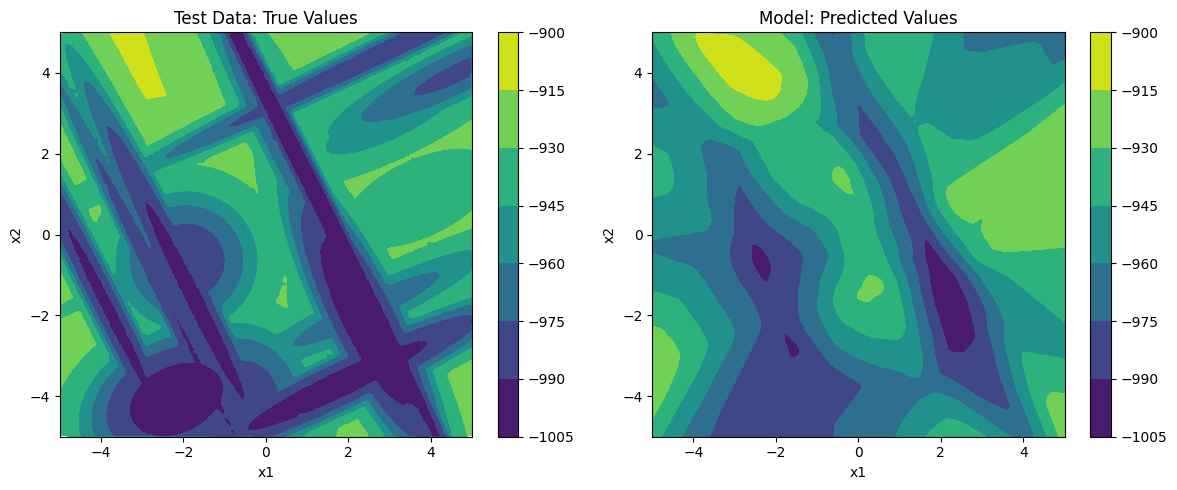

In [102]:
def plot_contour_comparison(
    model: nn.Module, test_dataloader: DataLoader, device: torch.device, x0=None, x1=None
) -> None:
    test_inputs_list = []
    test_targets_list = []

    for inputs, targets in test_dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        test_inputs_list.append(inputs.cpu().numpy())
        test_targets_list.append(targets.cpu().numpy())

    test_inputs = np.vstack(test_inputs_list)
    test_targets = np.concatenate(test_targets_list)

    x1_min, x1_max = test_inputs[:, 0].min(), test_inputs[:, 0].max()
    x2_min, x2_max = test_inputs[:, 1].min(), test_inputs[:, 1].max()
    x1_vals = np.linspace(x1_min, x1_max, 100)
    x2_vals = np.linspace(x2_min, x2_max, 100)
    X1, X2 = np.meshgrid(x1_vals, x2_vals)

    grid_points = np.column_stack((X1.flatten(), X2.flatten()))
    grid_tensor = torch.tensor(grid_points, dtype=torch.float32, device=device)

    model.eval()
    with torch.no_grad():
        predictions = model(grid_tensor).cpu().numpy().flatten()

    Z_pred = predictions.reshape(X1.shape)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    true_contour = ax1.tricontourf(
        test_inputs[:, 0], test_inputs[:, 1], test_targets.reshape(-1)
    )
    ax1.set_title("Test Data: True Values")
    ax1.set_xlabel("x1")
    ax1.set_ylabel("x2")
    plt.colorbar(true_contour, ax=ax1)

    pred_contour = ax2.contourf(X1, X2, Z_pred)
    ax2.set_title("Model: Predicted Values")
    ax2.set_xlabel("x1")
    ax2.set_ylabel("x2")
    plt.colorbar(pred_contour, ax=ax2)
    if x0 is not None and x1 is not None:
      ax2.scatter(x0, x1, color='red')

    plt.tight_layout()
    plt.show()

plot_contour_comparison(model, test_dataloader, device)

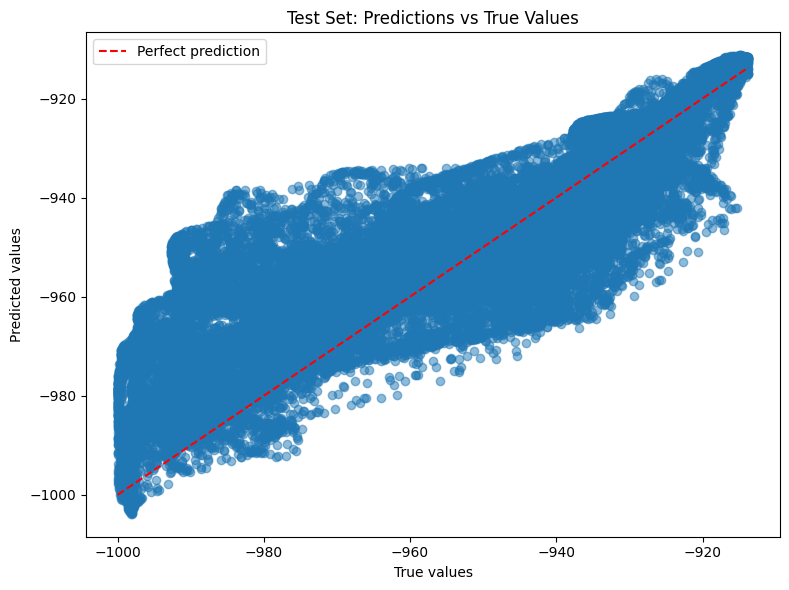

In [103]:
def plot_prediction_scatter(
    model: nn.Module, test_dataloader: DataLoader, device: torch.device
) -> None:
    test_targets_list = []
    test_preds_list = []

    for inputs, targets in test_dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        with torch.no_grad():
            outputs = model(inputs)

        test_targets_list.append(targets.cpu().numpy())
        test_preds_list.append(outputs.cpu().numpy())

    test_targets = np.concatenate(test_targets_list)
    test_preds = np.concatenate(test_preds_list).flatten()

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.scatter(test_targets, test_preds, alpha=0.5)
    ax.plot(
        [test_targets.min(), test_targets.max()],
        [test_targets.min(), test_targets.max()],
        "r--",
        label="Perfect prediction",
    )
    ax.set_xlabel("True values")
    ax.set_ylabel("Predicted values")
    ax.set_title("Test Set: Predictions vs True Values")
    ax.legend()

    plt.tight_layout()
    plt.show()


plot_prediction_scatter(model, test_dataloader, device)

### 5. Gradient-Based Optimization

Now, we optimize the trained MLP to find the input that minimizes its output (our surrogate's prediction).

In [104]:
def optimize_model(
    model: nn.Module, num_steps: int = 1000, alpha = 0.0001
) -> tuple[torch.Tensor, float]:
    """
    Perform gradient-based optimization on the MLP.

    Args:
        model (nn.Module): Trained MLP model.
        num_steps (int): Number of optimization steps.

    Returns:
        tuple: (best_x, best_y) - Optimal input and its predicted output.
    """
    model.eval()
    # Select random starting point in [-5, 5]^2
    x = torch.rand(1, 2, device=device) * 10 - 5
    x.requires_grad_(True)
    optimizer = torch.optim.Adam([x], lr=0.01)

    for _ in range(num_steps):
        optimizer.zero_grad()

        # Predict output (our output - result of the model is the function we want to minimize)
        output = model(x)

        # Compute gradients (gradients of our model)
        gradients = torch.autograd.grad(output, x, retain_graph=True)[0]

        # Update x
        x = x - alpha * gradients

        # Enforce domain constraints [-5, 5]
        x = torch.clamp(x, -5, 5)

    best_x = x.detach()
    best_y = model(best_x).detach()
    return best_x, best_y

optimize_model(model)

(tensor([[0.2808, 2.7417]], device='cuda:0'),
 tensor([[-977.7317]], device='cuda:0'))

### Exercise 1: Impact of Dataset Size
- **Task:** Train the MLP with different training set sizes (e.g., 100, 1000, 5000, 10000, 50000).
- **Instructions:**
  1. Modify the `train_perc` parameter in `prepare_dataloaders` to achieve these different dataset sizes (keep the test set size fixed at approximately 30,000 samples).
  2. Train the model for each dataset size and generate corresponding contour plots.
  3. Analyze how the MLP's ability to capture the underlying function structure (particularly the multimodal nature of f22) improves with increasing data volume.
  4. Select and justify a single quantitative metric that effectively captures the model’s predictive quality in this context. Use this metric to evaluate model performance across different training set sizes. Present the results as a plot to visualize how model quality scales with data availability.

Train size: 100
Validation size: 69900
Test size: 30000


100%|██████████| 100/100 [00:55<00:00,  1.79it/s]


Test Loss: 156850.3364


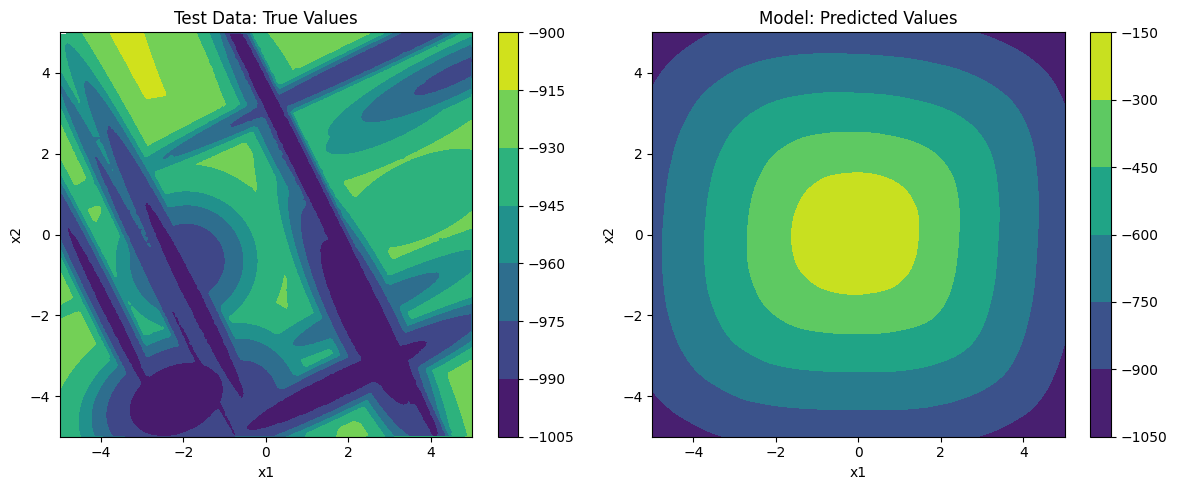

Train size: 1000
Validation size: 69000
Test size: 30000


 68%|██████▊   | 68/100 [00:38<00:18,  1.75it/s]

In [ ]:
for p in [0.001, 0.01, 0.05, 0.1, 0.5]:
    train_dataloader, val_dataloader, test_dataloader = prepare_dataloaders(
        "./bbob_f022_i01_d02_samples.csv", train_perc=p, val_perc=0.7-p
    )
    model = MLP().to(device)
    model, _, _ = train()
    plot_contour_comparison(model, test_dataloader, device)


### Exercise 2: Optimization Robustness
- **Task:** Implement the `optimize_model` function to find inputs that minimize the model's output.
- **Instructions:**
  1. Execute the optimization process multiple times (e.g. 10 for each dataset) with different random starting points and record the best surrogate values.
  2. Create a histogram of the best `y` values across all optimization runs to visualize the distribution of results.
  3. Generate a contour plot showing the locations of the solutions found. Analyze the consistency of these solutions.
  4. Use `cocoex` to evaluate the true objective function at the solution points. Compare these values against the surrogate’s predicted values.

In [ ]:
runs = 25
for dataset_id in ["01", "22"]:
    train_dataloader, val_dataloader, test_dataloader = prepare_dataloaders(
        f"./bbob_f0{dataset_id}_i01_d02_samples.csv", train_perc=0.5, val_perc=0.2
    )
    model, _, _ = train()
    history_x = []
    history_y = []
    for _ in tqdm(range(runs)):
        best_x, best_y = optimize_model(model)
        #print(f"Best x: {best_x}, Best y: {best_y}")
        history_x.append(best_x)
        history_y.append(best_y)
    history_x = torch.cat(history_x, dim=0)
    history_y = torch.cat(history_y, dim=0)
    x0 = history_x[:, 0].cpu()
    x1 = history_x[:, 1].cpu()
    history_y = history_y.cpu()
    print(f"Dataset ID: {dataset_id}\n\tBest y: {min(history_y)}")

    plot_contour_comparison(model, test_dataloader, device, x0, x1)
    plt.hist(history_y, bins=30)
    plt.title(f"Dataset ID: {dataset_id}")
    plt.show()


### Accessing Original COCO Benchmark Problems

The code below installs and imports the necessary packages to access the original COCO benchmark problems (f1 and f22).
This will allow us to compare our model's predictions with the true functions and evaluate optimization performance.

In [ ]:
! pip install coco-experiment cocopp

In [ ]:
from cocoex import Suite

function_id = 1  # Switch between 1 and 22 to change the function

suite = Suite(
    "bbob",
    "",
    f"function_indices: {function_id}, dimensions: 2 instance_indices: 1",
)
for function in suite:
    print(function.info)
    print("Function value at (0, 0):", function(np.array([0, 0])))

In [ ]:
function_id = 22  # Switch between 1 and 22 to change the function

suite = Suite(
    "bbob",
    "",
    f"function_indices: {function_id}, dimensions: 2 instance_indices: 1",
)
for function in suite:
    print(function.info)
    print("Function value at (0, 0):", function(np.array([0, 0])))